### Particle tracking in the Warnow Estuary
#### hydrodynamic filed from GTEM
### March 2018

In [1]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionDiffusionM1, ParcelsRandom
from operator import attrgetter

import numpy as np
from datetime import datetime, timedelta
import xarray as xr
import math

In [ ]:
dataset_folder = "HRO20m_results"
out_file = f"output/warnow_harbor.zarr"

In [10]:
filenames = {
    "U": f"{dataset_folder}/HRO20m.surf.2018*.nc4",
    "V": f"{dataset_folder}/HRO20m.surf.2018*.nc4",
}

variables = {
    "U": "uu",
    "V": "vv",
}

dimensions = {}

dimensions['U'] = {'lon': 'xc', 'lat': 'yc', 'time': 'time'}
dimensions['V'] = {'lon': 'xc', 'lat': 'yc', 'time': 'time'}

filenames['Kh_zonal']      = f"{dataset_folder}//HRO20m.surf.2018*.nc4"
filenames['Kh_meridional'] = f"{dataset_folder}//HRO20m.surf.2018*.nc4"

variables['Kh_zonal']      = 'AmC_3d'
variables['Kh_meridional'] = 'AmC_3d'

dimensions['Kh_zonal']      = {'lon': 'xc', 'lat': 'yc', 'time': 'time'}
dimensions['Kh_meridional'] = {'lon': 'xc', 'lat': 'yc', 'time': 'time'}

In [11]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions,
                                mesh='flat',
                                interp_method={'U': 'freeslip', 'V': 'freeslip','Kh_zonal':'linear',
                                               'Kh_meridional':'linear'}, allow_time_extrapolation=True)
 
fieldset.add_constant('dres', 10)

In [ ]:
pset = ParticleSet.from_line(
    fieldset=fieldset, 
    pclass=JITParticle, 
    start=(704440, 5998425),  # releasing on a line: the start longitude and latitude
    finish=(704760, 5998425), # releasing on a line: the end longitude and latitude
    size=10,
    time=0, #start from the beging of the ds
)

In [13]:
output_file = pset.ParticleFile(name=out_file, outputdt=timedelta(hours=1))
ParcelsRandom.seed(1636)

INFO: Compiled ParcelsRandom ==> /tmp/parcels-3454/parcels_random_cd7f7036-9055-4318-82ff-a22959b8be03.c


In [14]:
pset.execute([AdvectionDiffusionM1], 
             runtime=timedelta(days=15), 
             dt=timedelta(minutes=30),
             output_file=output_file)

INFO: Output files are stored in output/warnow_harbor.zarr.
100%|██████████| 1296000.0/1296000.0 [02:13<00:00, 9685.98it/s] 


#### QUICK VIEW

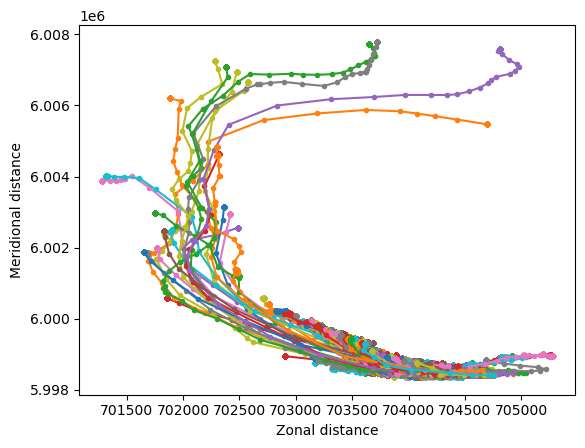

In [15]:
import matplotlib.pyplot as plt

ds = xr.open_zarr(f"output/warnow_harbor.zarr")

plt.plot(ds.lon.T, ds.lat.T, ".-")
plt.xlabel("Zonal distance")
plt.ylabel("Meridional distance")
plt.show()